In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

## Define list of the options to choose from and get from the function full URL string

In [4]:
## Symbols of the Investment Funds (with their Polish description)
number_to_symbol = {
    '1': '2711.n', # 'surowce'
    '2': '3187.n', # 'akcje_Metlife'
    '3': '1472.n', # 'akcje_Uniqa'
    '4': '4604.n', # 'makroalokacje_Uniqa'
    '5': '2735.n'  # 'zrownowazone_NN'
}

def URL_to_webscrapping(num):
    ## Make a url which including symbol from dictionary above 
    ## and date range for later webscraping Investment Fund prices
    symbol = number_to_symbol[str(num)]
    ## Both dates were taken as the examples only
    start_date = 20170101
    end_date = f"20{dt.date.today().strftime('%y%m%d')}"
    return f'https://stooq.com/q/d/l/?s={symbol}&d1={start_date}&d2={end_date}&i=d'

url_name = URL_to_webscrapping(4)
print(f'URL to web-scraping: {url_name} \n')

URL to web-scraping: https://stooq.com/q/d/l/?s=4604.n&d1=20170101&d2=20220605&i=d 



In [5]:
pd.read_csv(url_name).head()

,Date,Open,High,Low,Close
0,2017-01-02,103.25,103.25,103.25,103.25
1,2017-01-03,103.08,103.08,103.08,103.08
2,2017-01-04,103.24,103.24,103.24,103.24
3,2017-01-05,103.03,103.03,103.03,103.03
4,2017-01-09,102.66,102.66,102.66,102.66


In [6]:
pd.read_csv(url_name).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1329 entries, 0 to 1328
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1329 non-null   object 
 1   Open    1329 non-null   float64
 2   High    1329 non-null   float64
 3   Low     1329 non-null   float64
 4   Close   1329 non-null   float64
dtypes: float64(4), object(1)
memory usage: 52.0+ KB


### Are all columns with prices have the same values?

In [7]:
def price_cols_compare():
    _ = pd.read_csv(url_name)
    if ((_['Close']-_['Open']).sum() == 0.0):
        _ = _.drop(['Open'], axis=1)
    if ((_['High']-_['Low']).sum() == 0.0):
        _ = _.drop(['High', 'Low'], axis=1)
    return _

df = price_cols_compare()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1329 entries, 0 to 1328
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1329 non-null   object 
 1   Close   1329 non-null   float64
dtypes: float64(1), object(1)
memory usage: 20.9+ KB


### We will also change name of the 'Close' columns to 'Price'

In [8]:
df = df.rename(columns={'Close': 'Price'})

In [9]:
# convert to datetime64
df['Date'] = df['Date'].apply(pd.Timestamp)

## Set date as an index (it will not be take as a column into prediction)
df.set_index('Date', inplace=True)
df.head()

,Price
Date,
2017-01-02,103.25
2017-01-03,103.08
2017-01-04,103.24
2017-01-05,103.03
2017-01-09,102.66


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1329 entries, 2017-01-02 to 2022-05-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   1329 non-null   float64
dtypes: float64(1)
memory usage: 20.8 KB


### We have not enough data (columns) to make good predictions, so from column 'Price' will be calculated additionaly parameters: 
- 'Daily returns' (as a percent price change)
- 'MA30' (30 days moving average)
- 'STD30' (30 days standard deviation)
- 'Upper Band', 'Lower Band' (respectively: high and low value at exactly day)

In [11]:
df['Daily_returns'] = 100*(df['Price'].pct_change())
df['MA30'] = df['Price'].rolling(window=30).mean()
df['STD30'] = df['Price'].rolling(window=30).std()
df['Upper Band'] = df['MA30'] + (df['STD30'] * 2)
df['Lower Band'] = df['MA30'] - (df['STD30'] * 2)

df.head()

,Price,Daily_returns,MA30,STD30,Upper Band,Lower Band
Date,,,,,,
2017-01-02,103.25,NaN,NaN,NaN,NaN,NaN
2017-01-03,103.08,-0.164649,NaN,NaN,NaN,NaN
2017-01-04,103.24,0.155219,NaN,NaN,NaN,NaN
2017-01-05,103.03,-0.203410,NaN,NaN,NaN,NaN
2017-01-09,102.66,-0.359119,NaN,NaN,NaN,NaN


#### Plot with different prices over time

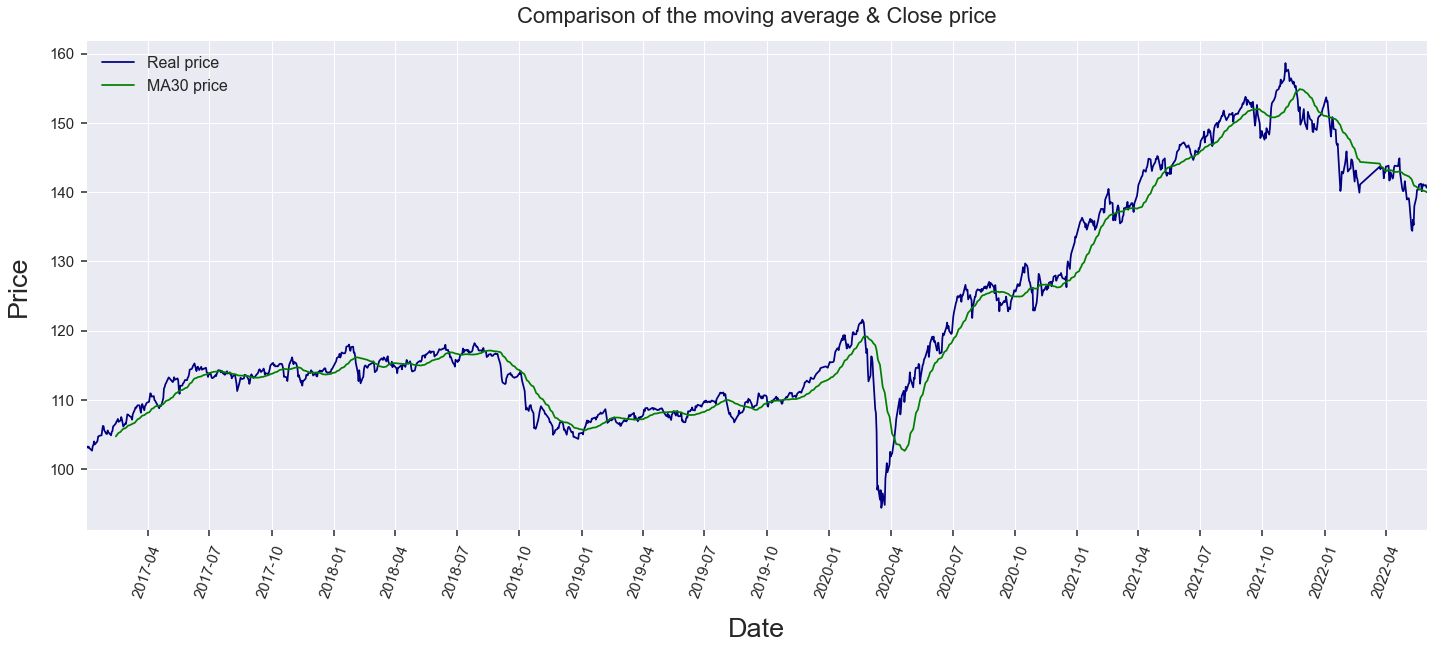

In [12]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(24, 9))

x = df.index

plt.plot(x, df['Price'], color='navy', label='Real price')
plt.plot(x, df['MA30'], color='green', label='MA30 price')
plt.xlim([x.min(), x.max()])
plt.xlabel('Date', fontdict={'fontsize':27}, labelpad=18)
plt.ylabel('Price', fontdict={'fontsize':27}, labelpad=18)
plt.tick_params(axis='x', width=1.5, length=6, labelsize=15, labelrotation=70)
plt.tick_params(axis='y', width=1.5, length=6, labelsize=15)
plt.title("Comparison of the moving average & Close price", fontsize=22, pad=18)
plt.legend(fontsize=16)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))

plt.show()

#### Plot with daily return (in percent)

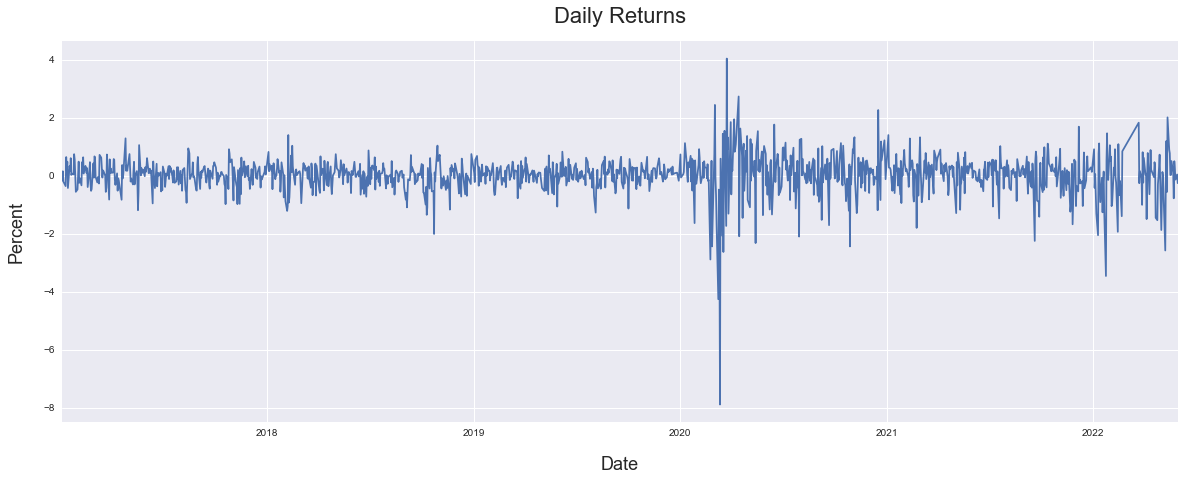

In [13]:
plt.figure(figsize=(20,7))

plt.plot(x, df['Daily_returns'])
plt.xlim([x.min(), x.max()])
plt.xlabel("Date", fontsize=18, labelpad=18)
plt.ylabel("Percent", fontsize=18, labelpad=18)
plt.title("Daily Returns", fontsize=22, pad=18)

plt.show()

#### Plot prices, moving average and both prices band

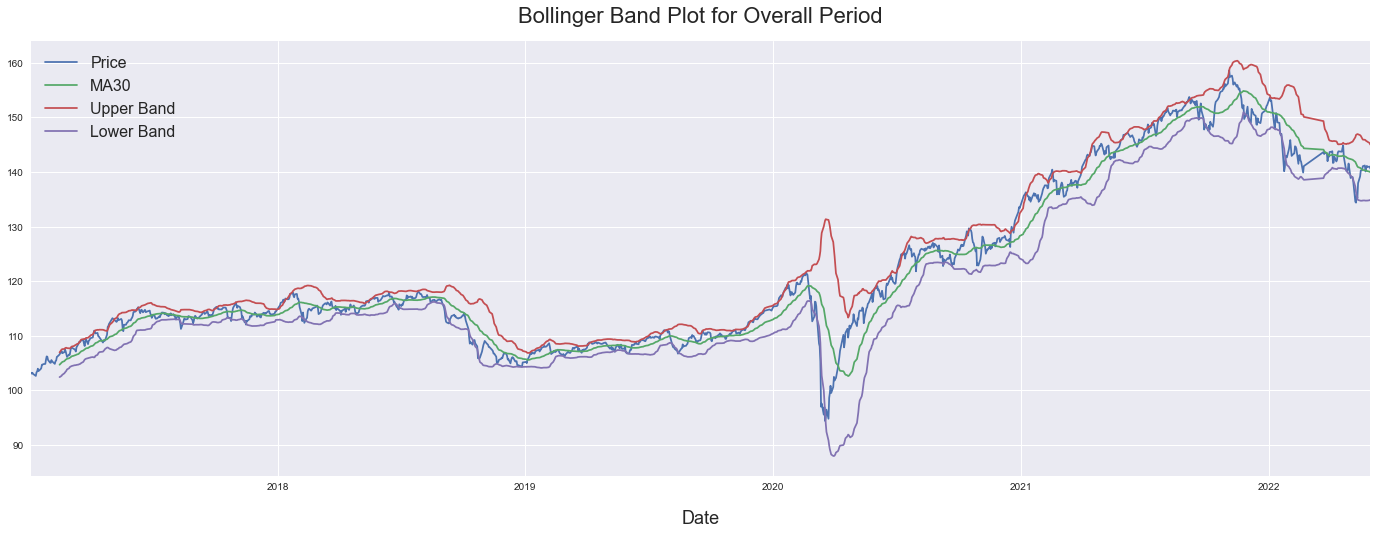

In [14]:
f = plt.figure(figsize=(24,8))

for i in ['Price', 'MA30', 'Upper Band', 'Lower Band']:
    plt.plot(x, df[i], label=f'{i}')

plt.xlabel("Date", fontsize=18, labelpad=18)
plt.ylabel('', fontsize=18, labelpad=18)
plt.xlim([x.min(), x.max()])
plt.title("Bollinger Band Plot for Overall Period", fontsize=22, pad=18)
plt.legend(fontsize=16)

plt.show()

## Prices prediction

In [15]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

#### Prepare features and target data

In [16]:
df = df.dropna()

X, y = df.drop(['Price'], axis=1), df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [17]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

### Linear regressor

In [18]:
from sklearn.linear_model import LinearRegression

linregr_model = LinearRegression(n_jobs=10)
linregr_model.fit(X_train, y_train)
ypred_linregr = linregr_model.predict(X_test)

print(f"Root Mean Squared Error={np.sqrt(mean_squared_error(y_test, ypred_linregr)):.3f}")
print(f"R^2 score={r2_score(y_test, ypred_linregr) * 100:.2f}%")
print(f"Train score={linregr_model.score(X_train, y_train) * 100:.2f}%")
print(f"Test Score={linregr_model.score(X_test, y_test) * 100:.2f}%")

Root Mean Squared Error=2.534
R^2 score=97.34%
Train score=97.06%
Test Score=97.34%


### **Decision tree**

In [19]:
from sklearn.tree import DecisionTreeRegressor

decisiontree_model = DecisionTreeRegressor(random_state=42)
decisiontree_model.fit(X_train, y_train)
ypred_decisiontree = decisiontree_model.predict(X_test)

In [20]:
from sklearn.ensemble import RandomForestRegressor

rf_params = {'n_estimators': range(10, 110, 10)}

rf_model = GridSearchCV(RandomForestRegressor(warm_start=True, n_jobs=10, random_state=42),
                                             rf_params, refit=True, cv=5)
rf_model.fit(X_train, y_train)

print(rf_model.best_params_)
print(rf_model.best_score_)

rf_best_model = RandomForestRegressor(**rf_model.best_params_)
ypred_rf = rf_best_model.fit(X_train, y_train).predict(X_test)

{'n_estimators': 80}
0.9909663972509932


### SVR algorythms

In [21]:
from sklearn.svm import SVR, LinearSVR

SVMlinear_regr = LinearSVR(random_state=42, max_iter=1e6)
SVM_regr = SVR(shrinking=True, cache_size=1000)

# Autotune best result for different input parameters
linear_parameters = {'C': np.logspace(-5, 2, 30),
                     'epsilon': np.linspace(0.05, 0.95, 19)}

poly_parameters = {'C': np.linspace(0.01, 1, 20),
                   'degree': [3],
                   'epsilon': np.logspace(-3, -0.5, 5)}

rbf_parameters = {'C': np.linspace(0.01, 1, 20),
                  'epsilon': np.logspace(-3, -0.5, 5)}

In [22]:
SVRlinear_model = GridSearchCV(SVMlinear_regr, linear_parameters, refit=True, n_jobs=10, cv=5)
SVRlinear_model.fit(X_train, y_train)

print('For SVR_linear_regressor:')
print(SVRlinear_model.best_params_)
print(SVRlinear_model.best_score_, '\n')

SVRlinear_best_model = LinearSVR(**SVRlinear_model.best_params_)
ypred_SVRlinear = SVRlinear_best_model.fit(X_train, y_train).predict(X_test)

For SVR_linear_regressor:
{'C': 0.6723357536499335, 'epsilon': 0.05}
0.9689782272216935 



In [23]:
SVRpoly_model = GridSearchCV(SVM_regr, poly_parameters, refit=True, n_jobs=10, cv=5)
SVRpoly_model.fit(X_train, y_train)

print('For SVR_linear_regressor:')
print(SVRpoly_model.best_params_)
print(SVRpoly_model.best_score_, '\n')

SVRpoly_best_model = SVR(**SVRpoly_model.best_params_)
ypred_SVRpoly = SVRpoly_best_model.fit(X_train, y_train).predict(X_test)

For SVR_linear_regressor:
{'C': 1.0, 'degree': 3, 'epsilon': 0.001}
0.9458184143382949 



In [24]:
SVRrbf_model = GridSearchCV(SVM_regr, rbf_parameters, refit=True, n_jobs=10, cv=5)
SVRrbf_model.fit(X_train, y_train)

print('For SVR_linear_regressor:')
print(SVRrbf_model.best_params_)
print(SVRrbf_model.best_score_, '\n')

SVRrbf_best_model = SVR(**SVRrbf_model.best_params_)
ypred_SVRrbf = SVRrbf_best_model.fit(X_train, y_train).predict(X_test)

For SVR_linear_regressor:
{'C': 1.0, 'epsilon': 0.001}
0.9458184143382949 



### Nearest neighbours

In [25]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()

# Autotune best result for different input parameters
parameters = {'n_neighbors': np.arange(3, 10, 2),
              'weights': ['uniform', 'distance'],
              'algorithm': ['ball_tree', 'kd_tree', 'brute'],
              'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']}

knn_regr = GridSearchCV(knn, parameters, refit=True, n_jobs=10, cv=5)
knn_regr.fit(X_train, y_train)

print(knn_regr.best_params_)
print(knn_regr.best_score_)

knn_regr_best_model = KNeighborsRegressor(**knn_regr.best_params_)
ypred_knn = knn_regr_best_model.fit(X_train, y_train).predict(X_test)

{'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
0.9838813071022632


### Graphical comparison of the real and calculating values

In [29]:
def Sort_results(cols):
    ## cols is 'y_test' or 'y_pred'
    _ = pd.DataFrame([y_test.index, cols]).T
    _ = _.sort_values(by=[0]).reset_index(drop=True)
    _.set_index(0, inplace=True)
    return _

## 2 constant columns for plotting the results
time_plot, y_plot = Sort_results(y_test).index, Sort_results(y_test).iloc[:,0]

#### Define lists to make one plot with the all regressors

In [30]:
regr_names = ['LinearRegr','DecisionTree','RandomTree','SVRLinear','SVRpoly','SVRrbf','KNNRegr']
colors = ['brown', 'orange', 'green', 'red', 'black', 'pink', 'violet']
y_pred_list = [Sort_results(i).iloc[:, 0] for i in [ypred_linregr, ypred_decisiontree, ypred_rf,
ypred_SVRlinear, ypred_SVRpoly, ypred_SVRrbf, ypred_knn]]

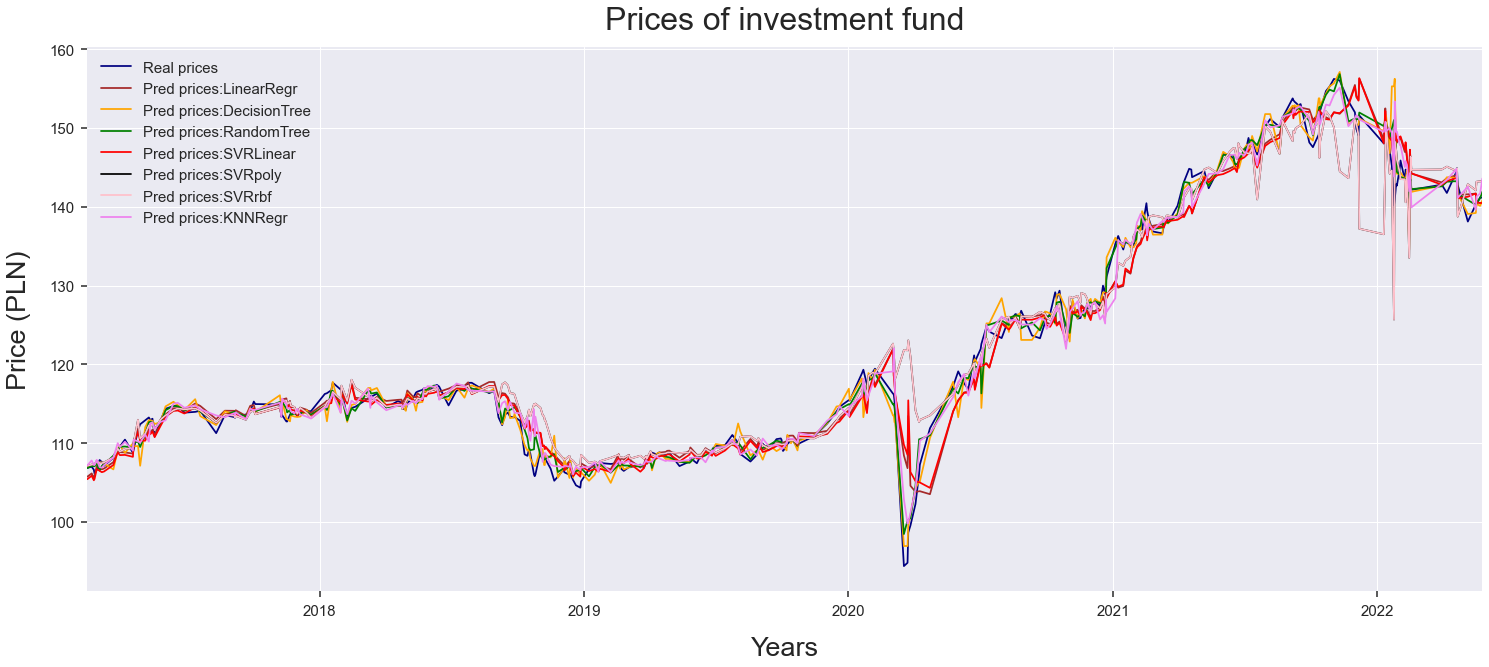

In [31]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(25, 10))


plt.plot(time_plot, y_plot, c='navy', label='Real prices')

for y_pred, color, name in zip(y_pred_list, colors, regr_names):
    plt.plot(time_plot, y_pred, c=color, label=f'Pred prices:{name}')

plt.xlim((time_plot.min(), time_plot.max()))
plt.xlabel('Years', fontdict={'fontsize':27}, labelpad=18)
plt.ylabel('Price (PLN)', fontdict={'fontsize':27}, labelpad=18)
plt.tick_params(axis='both', width=1.5, length=6, labelsize=15)
plt.title('Prices of investment fund', fontdict={'fontsize':32}, pad=18)
plt.legend(fontsize=15)

plt.show()